In [40]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

# Predicting Hospital Readmission

### Introduction


### Attributes
- `encounter_id`: Unique identifier of an encounter.
- `patient_nbr`: Unique identifier of a patient.
- `race`: Caucasian, Asian, African American, Hispanic, and other.
- `gender`: male, female, and unknown/invalid.
- `age`: Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100).
- `weight`: Weight in pounds.
- `admission_type_id`: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available.
- `discharge_disposition_id`: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available.
- `admission source_id`: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital.
- `time_in_hospital`: Integer number of days between admission and discharge.
- `payer_code`: Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay.
- `medical_specialty`: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon.
- `num_lab_procedures`: Number of lab tests performed during the encounter.
- `numb_procedures`: Number of procedures (other than lab tests) performed during the encounter.
- `num_medications`: Number of distinct generic names administered during the encounter.
- `number_outpatient`: Number of outpatient visits of the patient in the year preceding the encounter.
- `number_emergency`: Number of emergency visits of the patient in the year preceding the encounter.
- `number_inpatient`: Number of inpatient visits of the patient in the year preceding the encounter.
- `diag_1`: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values.
- `diag_2`: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values.
- `diag_3`: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values.
- `number_diagnoses`: Number of diagnoses entered to the system
- `max_glu_serum`: Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured.
- `A1Cresult`: Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
- `change`: Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”.
- `diabetesMed`: Indicates if there was any diabetic medication prescribed. Values: "yes" and "no".
- 24 features for medications: Medications under their generic names: `metformin`, `repaglinide`, `nateglinide`, `chlorpropamide`, `glimepiride`, `acetohexamide`, `glipizide`, `glyburide`, `tolbutamide`, `pioglitazone`, `rosiglitazone`, `acarbose`, `miglitol`, `troglitazone`, `tolazamide`, `examide`, `sitagliptin`, `insulin`, `glyburide-metformin`, `glipizide-metformin`, `glimepiride-pioglitazone`, `metformin-rosiglitazone`, and `metformin- pioglitazone`. The feature indicates whether the drug was prescribed or there was a change in the dosage. _Values: up if the dosage was increased during the encounter, down if the dosage was decreased, steady if the dosage did not change, and no if the drug was not prescribed._
- `readmitted`: Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission


#### Note on dataset size

One problem with this dataset is that there are _a lot_ of categorical attributes - one hot encoding the dataset with minimal feature engineering results in over 2,500 columns. While this may also impact model accuracy, training models with 2500 columns and over 100,000 observations is very computationally intensive and therefore impractical. 

## Imports & Read Data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns


from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
# # read data
# PATH_df = r'C:\Users\alindsey\Documents\hospital_readmissions\Data\Raw\diabetic_data.csv'
# PATH_codes = r'C:\Users\alindsey\Documents\hospital_readmissions\Data\Raw\IDs_mapping.csv'
# df = pd.read_csv(PATH_df)
# codes = pd.read_csv(PATH_codes)

In [3]:
# # read data MAC
df = pd.read_csv('Data/Raw/diabetic_data.csv')
codes = pd.read_csv('Data/Raw/IDs_mapping.csv')

## Clean Data

### codes

In [4]:
# clean ids_mapping.csv, imported as codes
codes = codes[(codes['description']!='description')] 

# merge
codes = pd.merge(codes.copy()[40:].rename(columns={'description':'admission_source_id',
                                                     'admission_type_id':'values'}),
                 (pd.merge(codes.copy()[0:8].rename(columns={'description':'admission_type_id',
                                                             'admission_type_id':'values'}),
                           codes.copy()[9:39].rename(columns={'description':'discharge_disposition_id',
                                                              'admission_type_id':'values'}),
                           how='outer',
                           left_on='values',
                           right_on='values')),
                 how='outer',
                 left_on='values',
                 right_on='values').reset_index(drop=True)

# some NAN should actually be NULL
codes.loc[15, 'admission_source_id'] = 'NULL'
codes.loc[5, 'admission_type_id'] = 'NULL'
codes.loc[16, 'discharge_disposition_id'] = 'NULL'
codes.head(10)

,values,admission_source_id,admission_type_id,discharge_disposition_id
0,1,Physician Referral,Emergency,Discharged to home
1,2,Clinic Referral,Urgent,Discharged/transferred to another short term h...
2,3,HMO Referral,Elective,Discharged/transferred to SNF
3,4,Transfer from a hospital,Newborn,Discharged/transferred to ICF
4,5,Transfer from a Skilled Nursing Facility (SNF),Not Available,Discharged/transferred to another type of inpa...
5,6,Transfer from another health care facility,NULL,Discharged/transferred to home with home healt...
6,7,Emergency Room,Trauma Center,Left AMA
7,8,Court/Law Enforcement,Not Mapped,Discharged/transferred to home under care of H...
8,9,Not Available,NaN,Admitted as an inpatient to this hospital
9,10,Transfer from critial access hospital,NaN,Neonate discharged to another hospital for neo...


### Primary df

In [5]:
# replace ? with NaN
df.replace('?', np.nan, inplace=True)

# drop encounter_id
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

# make outcome variable binary
df['readmitted'].replace({'<30':'YES', '>30':'YES'}, inplace=True)
df.head(10)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,YES
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Initial Investigation

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    3197 non-null    object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                61510 non-null   object
 9   medical_specialty         51817 non-null   object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-null  int64 
 14  numb

In [9]:
pd.options.display.float_format = "{:.2f}".format # two decimal places
df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00
mean,2.02,3.72,5.75,4.40,43.10,1.34,16.02,0.37,0.20,0.64,7.42
std,1.45,5.28,4.06,2.99,19.67,1.71,8.13,1.27,0.93,1.26,1.93
min,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00
25%,1.00,1.00,1.00,2.00,31.00,0.00,10.00,0.00,0.00,0.00,6.00
50%,1.00,1.00,7.00,4.00,44.00,1.00,15.00,0.00,0.00,0.00,8.00
75%,3.00,4.00,7.00,6.00,57.00,2.00,20.00,0.00,0.00,1.00,9.00
max,8.00,28.00,25.00,14.00,132.00,6.00,81.00,42.00,76.00,21.00,16.00


### Missing Values

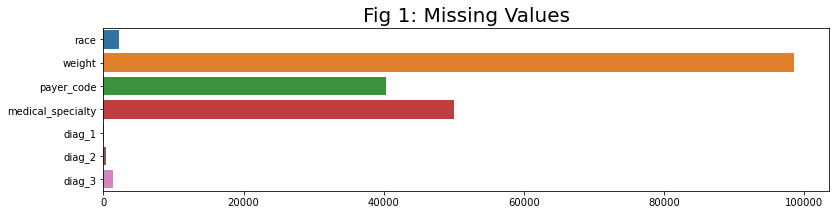

In [10]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.barplot(x=df.isnull().sum()[df.isnull().sum()>0],
            y=df.columns[df.isna().any()].tolist(),
            orient='h')

plt.title('Fig 1: Missing Values', size=20);

## Impute Missing Values

In [11]:
df.rename(columns={'diag_1':'diagnosis'}, inplace=True)

In [12]:
for i in df.index:
    current_race = df.at[i, 'race']
    current_diag_1 = df.at[i, 'diagnosis']
    
    if pd.isnull(current_race)==True:
        df.at[i, 'race'] = 'Caucasian'
    
    if pd.isnull(current_diag_1)==True:
        df.at[i, 'diagnosis'] = 428

#### Drop Columns

Over 90% of `weight` is missing, so it is dropped from the dataset. `payer_code`, `medical_specialty` are both dropped as nearly 50% are missing. 

The other variables are missing a small percentage of their observations.

In [13]:
cols_to_drop = ['weight',
                'payer_code',
                'medical_specialty',
                'diag_2',
                'diag_3',
                'metformin-pioglitazone',
                'metformin-rosiglitazone',
                'glimepiride-pioglitazone',
                'citoglipton',
                'examide',
                'tolazamide',
                'troglitazone',
                'miglitol',
                'acarbose',
                'acetohexamide',
                'chlorpropamide',
                'glipizide-metformin']

df.drop(cols_to_drop, axis=1, inplace=True)

## Categorization of Diagnoses

There are hundreds of different diagnoses here. The broad categories are available [here](https://en.wikipedia.org/wiki/List_of_ICD-9_codes). 

In [14]:
for i in df.index:
    d = df.at[i, 'diagnosis']
    
    try:
        d = float(df.at[i, 'diagnosis'])
        
    except ValueError:
        df.at[i, 'diagnosis'] = 'other'
    
    else:
        if d>=1 and d<=139:
            df.at[i, 'diagnosis'] = 'infections/parasitic'
        elif d>=140 and d<=239:
            df.at[i, 'diagnosis'] = 'neoplasms'
        elif d>=240 and d<=279:
            df.at[i, 'diagnosis'] = 'endocrine/nutrition/immunity'
        elif d>= 280 and d<=289:
            df.at[i, 'diagnosis'] = 'blood'
        elif d>=290 and d<=319:
            df.at[i, 'diagnosis'] = 'mental disorders'
        elif d>=320 and d<=329:
            df.at[i, 'diagnosis'] = 'nervous system'
        elif d>=390 and d<=459:
            df.at[i, 'diagnosis'] = 'circulatory'
        elif d>=460 and d<=519:
            df.at[i, 'diagnosis'] = 'respiratory'
        elif d>=520 and d<=579:
            df.at[i, 'diagnosis'] = 'digestive'
        elif d>=580 and d<=629:
            df.at[i, 'diagnosis'] = 'genitourinary'
        elif d>=630 and d<=679:
            df.at[i, 'diagnosis'] = 'pregnancy/childbirth'
        elif d>=680 and d<=709:
            df.at[i, 'diagnosis'] = 'skin/subcutaneous tissue'
        elif d>=710 and d<=739:
            df.at[i, 'diagnosis'] = 'musculoskeletal'
        elif d>=740 and d<=759:
            df.at[i, 'diagnosis'] = 'congenital anomalies'
        elif d>=760 and d<=779:
            df.at[i, 'diagnosis'] = 'perinatal'
        elif d>=780 and d<=799:
            df.at[i, 'diagnosis'] = 'ill-defined'
        else:
            df.at[i, 'diagnosis'] = 'injury/poisoning'

100%|██████████| 101766/101766 [00:01<00:00, 69591.66it/s]


## Exploratory Analysis

### Readmitted - Variable of Interest

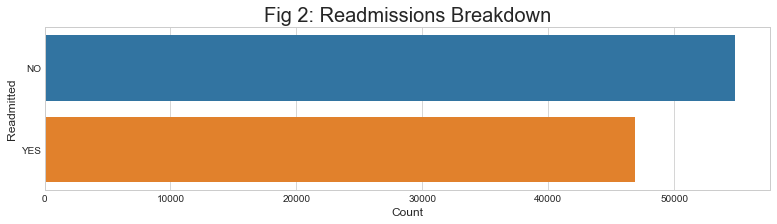

In [36]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.countplot(y='readmitted', data=df)
plt.title('Fig 2: Readmissions Breakdown', size=20)
plt.xlabel('Count', size=12)
plt.ylabel('Readmitted', size=12);

### Non-Drug Features vs. Readmission (Non-Drugs)

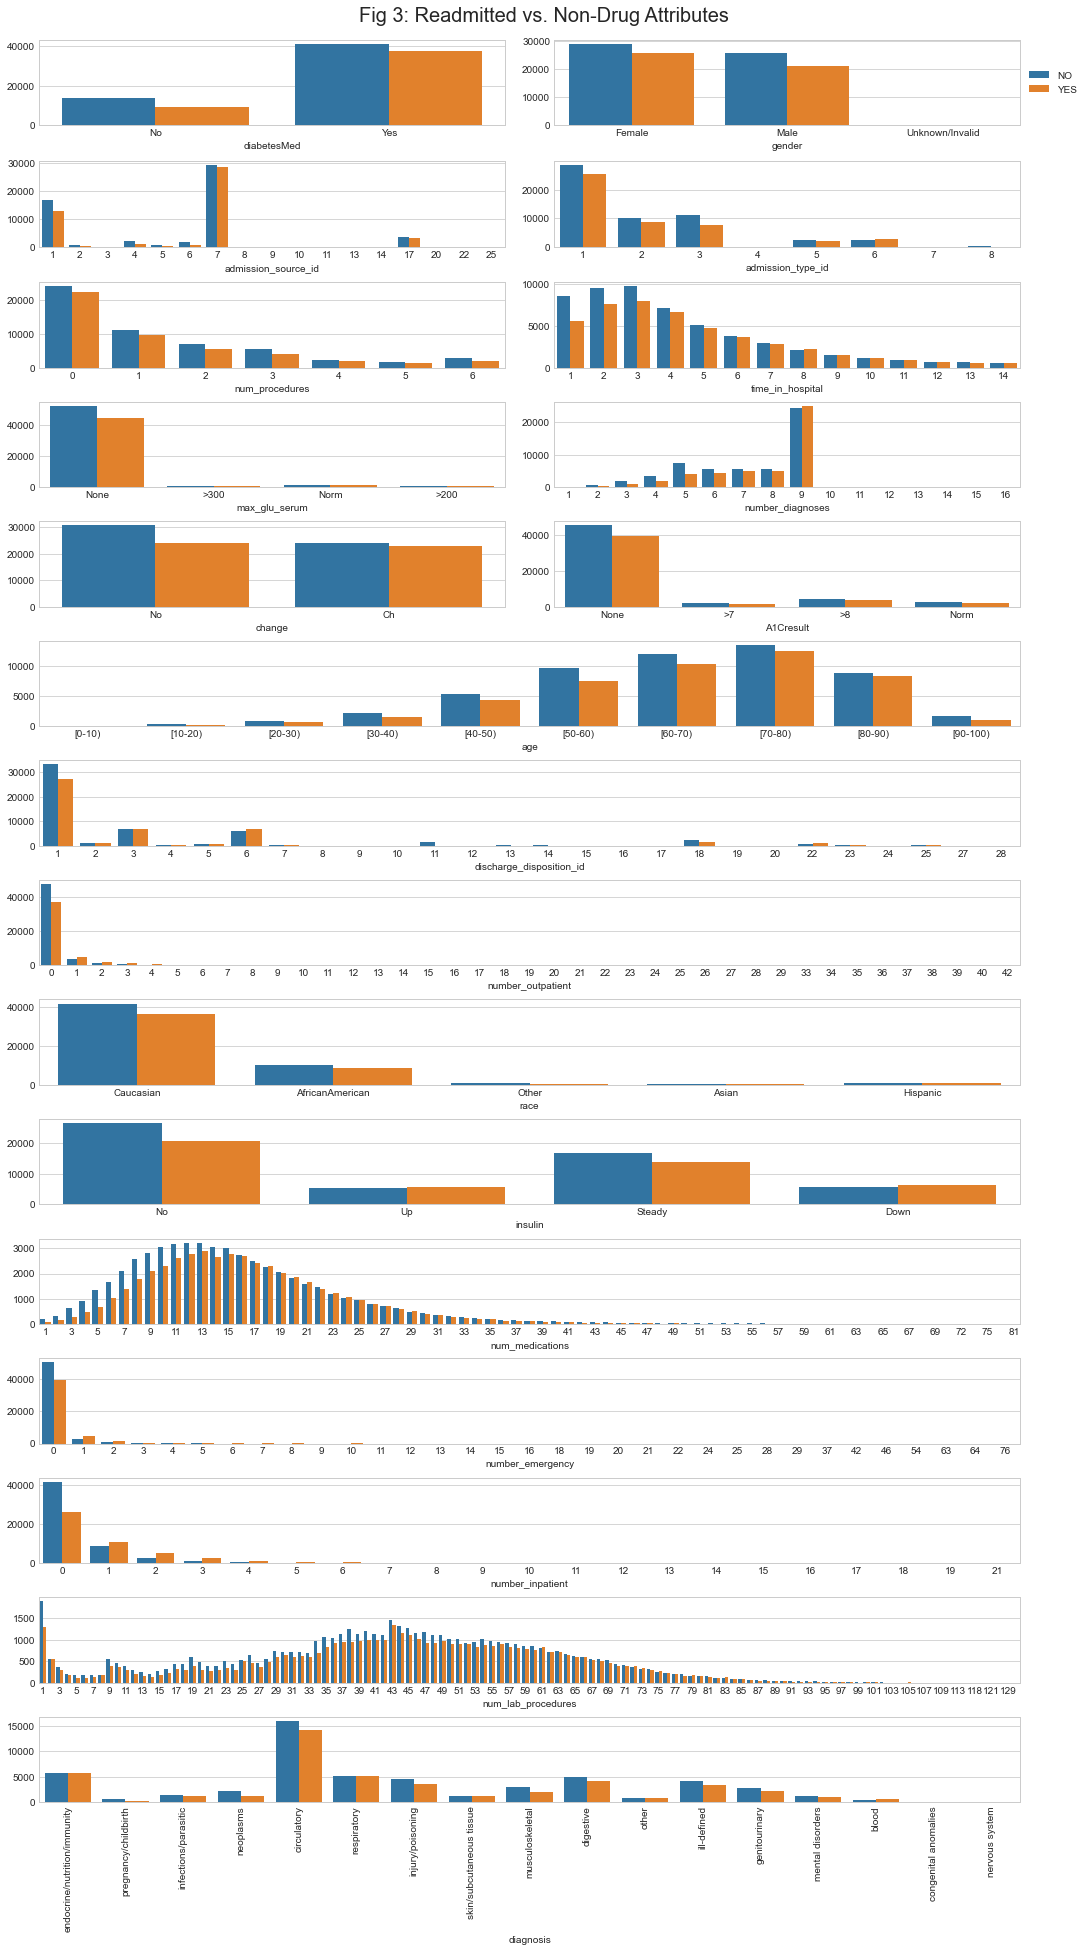

In [39]:
columns = ['gender',
           'diabetesMed',
           'admission_type_id',
           'admission_source_id',
           'time_in_hospital',
           'num_procedures',
           'number_diagnoses',
           'max_glu_serum',
           'A1Cresult',
           'change',
           'age',
           'discharge_disposition_id',
           'number_outpatient',
           'race',
           'insulin',           
           'num_medications',
           'number_emergency',
           'number_inpatient',
           'num_lab_procedures',
           'diagnosis']

def print_countplots(fig, columns, hue, df=df, col_pos=0):
    for i, ax in enumerate(fig.axes):
        sns.countplot(x=df[columns[col_pos]], hue=hue, ax=ax)
        ax.get_legend().remove()
        ax.set_ylabel('')

        if df[columns[col_pos]].name == 'diagnosis':
            _ = plt.xticks(rotation=90)
            
        if df[columns[col_pos]].name == 'num_lab_procedures' or df[columns[col_pos]].name == 'num_medications':
            n=2
            [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
            
        if ax == ax0:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        col_pos += 1

fig = plt.figure(constrained_layout=True, figsize=(15, 27))
gs = GridSpec(15, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, 1:])
ax0_ = fig.add_subplot(gs[0, :1])
ax1 = fig.add_subplot(gs[1, 1:])
ax1_ = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[2, 1:])
ax2_ = fig.add_subplot(gs[2, :1])
ax3 = fig.add_subplot(gs[3, 1:])
ax3_ = fig.add_subplot(gs[3, :1])
ax4 = fig.add_subplot(gs[4, 1:])
ax4_ = fig.add_subplot(gs[4, :1])
ax5 = fig.add_subplot(gs[5, :])
ax6 = fig.add_subplot(gs[6, :])
ax7 = fig.add_subplot(gs[7, :])
ax8 = fig.add_subplot(gs[8, :])
ax9 = fig.add_subplot(gs[9, :])
ax10 = fig.add_subplot(gs[10, :])
ax11 = fig.add_subplot(gs[11, :])
ax12 = fig.add_subplot(gs[12, :])
ax13 = fig.add_subplot(gs[13, :])
ax14 = fig.add_subplot(gs[14, :])


print_countplots(fig=fig, columns=columns, hue=df['readmitted'])
fig.suptitle("Fig 3: Readmitted vs. Non-Drug Attributes", size=20);

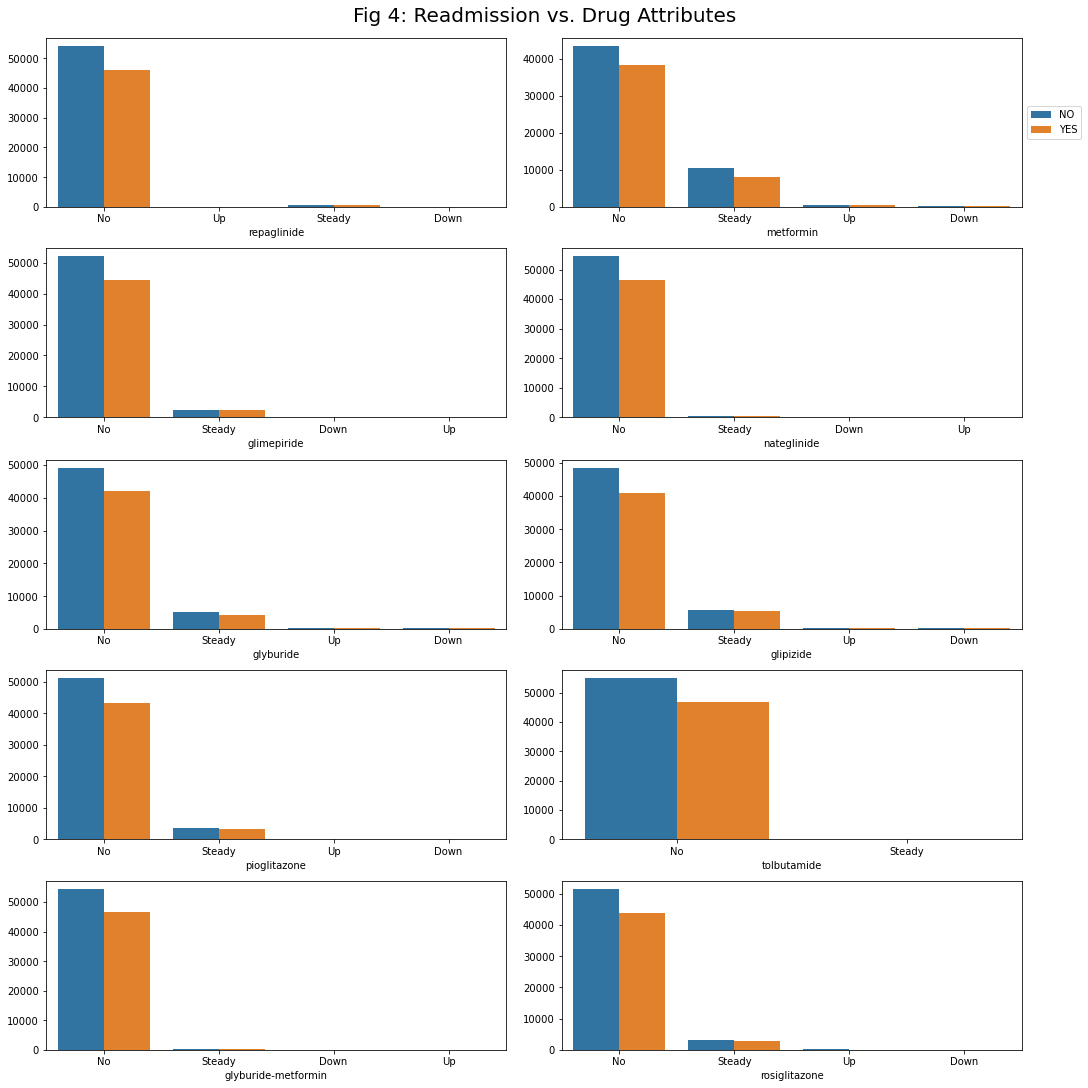

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))
gs = GridSpec(5, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, 1:])
ax0_ = fig.add_subplot(gs[0, :1])
ax1 = fig.add_subplot(gs[1, 1:])
ax1_ = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[2, 1:])
ax2_ = fig.add_subplot(gs[2, :1])
ax3 = fig.add_subplot(gs[3, 1:])
ax3_ = fig.add_subplot(gs[3, :1])
ax4 = fig.add_subplot(gs[4, 1:])
ax4_ = fig.add_subplot(gs[4, :1])

print_countplots(fig=fig,
                 columns=[col for col in df.columns.drop(['readmitted']) if col not in columns],
                 hue=df['readmitted'])
fig.suptitle("Fig 4: Readmission vs. Drug Attributes", size=20);

# Feature Engineering

## How many times seen before

## Number outpatient

For 

# Encode Variables

In [23]:
# find categorical and continuous columns
continuous_cols = []
categorical_cols = []
for c in df.columns:
    if df[c].dtype=='int64':
        if 'id' not in c:
            continuous_cols.append(c)
        else:
            categorical_cols.append(c)
    else:
        categorical_cols.append(c)

In [24]:
df_ohe = pd.get_dummies(data=df, columns=categorical_cols, drop_first=True)

# Splitting - Train & Test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_ohe.drop(['readmitted_YES'], axis=1), 
                                                    df_ohe['readmitted_YES'],
                                                    train_size=.75,
                                                    shuffle=True,
                                                    random_state=1)

# Scaling

In [26]:
ct = ColumnTransformer(transformers=[('scaler', StandardScaler(), continuous_cols)],
                       remainder='passthrough')

In [27]:
X_train = pd.DataFrame(ct.fit_transform(X_train),
                       columns=X_train.columns)
X_train.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,rosiglitazone_Steady,rosiglitazone_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes
0,2.22,0.40,-0.20,-0.50,-0.29,-0.21,0.29,0.30,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00
1,-0.47,-1.43,-0.78,-0.86,1.27,-0.21,1.08,-1.25,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2,-0.47,0.60,-0.78,-0.50,-0.29,-0.21,-0.50,0.82,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
3,-1.14,-1.03,0.39,-1.85,-0.29,-0.21,-0.50,-1.25,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
4,-0.13,-0.06,-0.78,-0.62,2.05,-0.21,-0.50,-1.25,0.00,1.00,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00


# Analysis

In [28]:
scores = {} # create empty dict to store models and cross validation best scores

def results(estimator):
    """
    1. Adds fitted model and best score from RandomizedSearchCV to scores dictionary.
    2. Prints fitted model best parameters and best score
    """
    scores[estimator] = estimator.best_score_ # add fitted model and .best_score_ to models dictionary
    return print(f'Best params: {estimator.best_params_}'+ f'\nBest estimator score: {estimator.best_score_}')

In [29]:
# # Logistic Regression, no regularization
# params = {'C':list(range(1, 10))}
# logistic = RandomizedSearchCV(LogisticRegression(penalty='none',
#                                                  solver='lbfgs'), 
#                               param_distributions=params, 
#                               n_jobs=-1, 
#                               cv=5,
#                               verbose=1)
# logistic.fit(X_train, y_train)
# results(logistic)

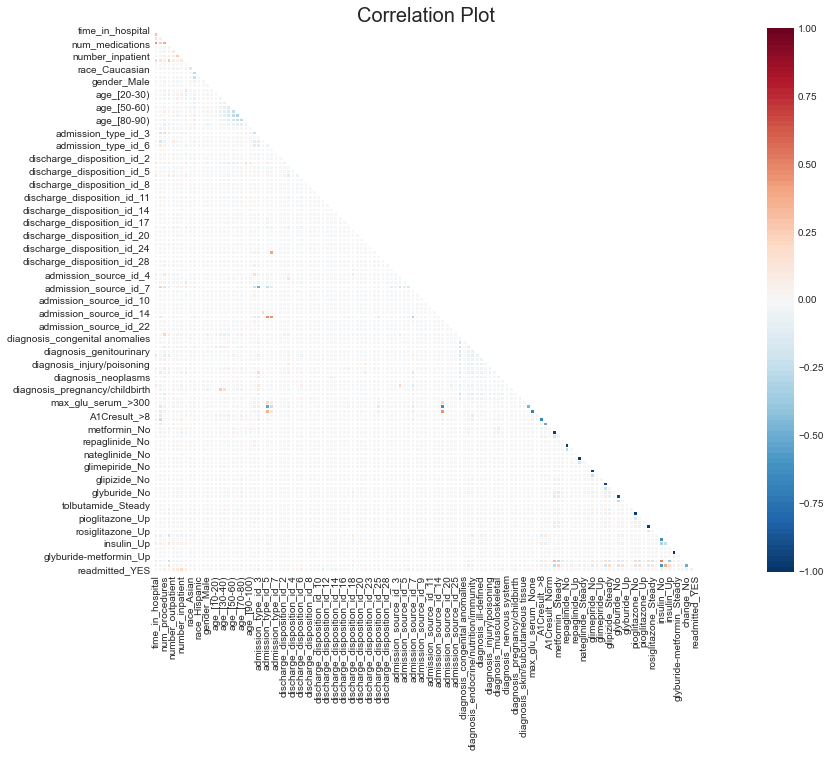

In [30]:
# def corr_plot(df, title='Correlation Plot', figsize=(25, 10), max_cols=20):
#     """
#     Prints correlation plot. If number of columns > max_cols then annotations are turned off. 
#     """
  
#     plt.style.use('seaborn-whitegrid')
#     fig = plt.figure(figsize=figsize)
#     mask = np.zeros_like(df.corr(), dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True
    
#     # if too many columns, plot gets messy because of in-box annotations
#     if len(df.columns)>max_cols:
#         annot = False
#     else:
#         annot = True   
    
#     sns.heatmap(df.corr(),
#                 annot=annot,
#                 vmin=-1, vmax=1,
#                 square=True, 
#                 cmap=sns.color_palette('RdBu_r', 100),
#                 mask=mask,
#                 linewidths=0.5)
#     # title
#     plt.title(title, size=20)

# corr_plot(df_ohe)